In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/323232323/5390813023616234241.jpg


In [21]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 64
epochs = 3
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.logsoftmax(self.fc2(x))
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SimpleCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs + 1):
    total_loss = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

model.eval()
correct = 0
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
accuracy = correct / len(test_loader.dataset)
print(f"CNN test accuracy: {accuracy:.4f}")

100%|██████████| 938/938 [00:12<00:00, 75.52it/s]


Epoch 1/3, Loss: 0.1357


100%|██████████| 938/938 [00:12<00:00, 75.62it/s]


Epoch 2/3, Loss: 0.0451


100%|██████████| 938/938 [00:12<00:00, 75.89it/s]


Epoch 3/3, Loss: 0.0301


100%|██████████| 157/157 [00:01<00:00, 86.22it/s]

CNN test accuracy: 0.9891


In [180]:
def recognize_and_annotate(input_path, output_path=None, show=False):
    def zoom_to_center(img, zoom_factor=1.5):
        h, w = img.shape[:2]
        new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
        cy, cx = h // 2, w // 2
    
        # Координаты обрезки
        y1 = max(cy - new_h // 2, 0)
        y2 = min(cy + new_h // 2, h)
        x1 = max(cx - new_w // 2, 0)
        x2 = min(cx + new_w // 2, w)
    
        # Вырезаем центральную часть и растягиваем обратно
        cropped = img[y1:y2, x1:x2]
        zoomed = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
        return zoomed

    
    img_color = cv2.imread(input_path)
    img_color = zoom_to_center(img_color, zoom_factor=1.5)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    h_img, w_img = thresh.shape
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect = w / float(h)

        if area < 1000 or w < 60 or h < 60:
            continue
        if w > 0.4 * w_img and h > 0.4 * h_img:
            continue
        if aspect > 1.2 or aspect < 0.3:
            continue

        pad = int(0.2 * max(w, h))
        x1 = max(x - pad, 0)
        y1 = max(y - pad, 0)
        x2 = min(x + w + pad, w_img)
        y2 = min(y + h + pad, h_img)

        roi = thresh[y1:y2, x1:x2]
        roi_resized = cv2.resize(roi, (28,28), interpolation=cv2.INTER_AREA)
        tensor = (torch.tensor(roi_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0).to(device)
        with torch.no_grad():
            pred = model(tensor).argmax(dim=1).item()
        regions.append((x1, y1, x2 - x1, y2 - y1, pred))

    regions.sort(key=lambda r: r[0])

    for x, y, w, h, pred in regions:
        cv2.rectangle(img_color, (x,y), (x+w,y+h), (0,255,0), 2)
        cv2.putText(img_color, str(pred), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    if output_path:
        cv2.imwrite(output_path, img_color)
    if show:
        import matplotlib.pyplot as plt
        img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6))
        plt.imshow(img_rgb); plt.axis('off')
        plt.show()

    return [r[4] for r in regions]

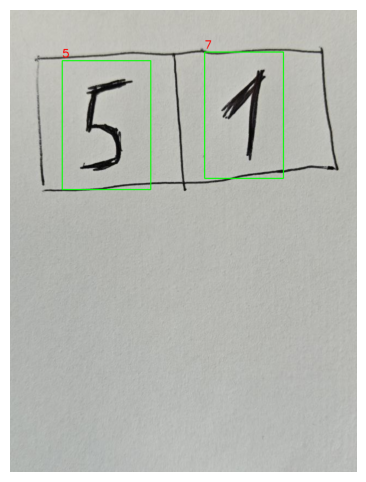

[5, 7]


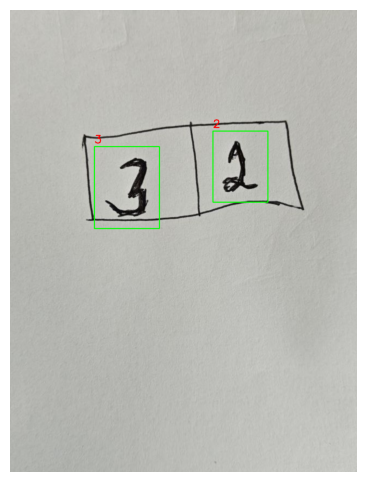

[3, 2]


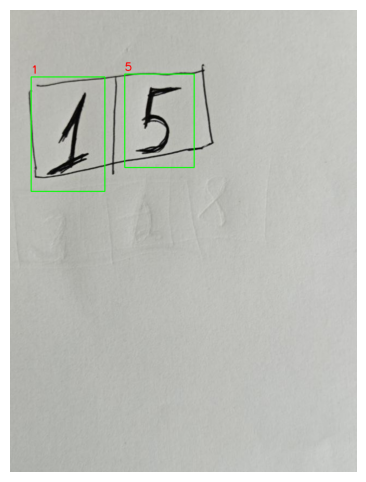

[1, 5]


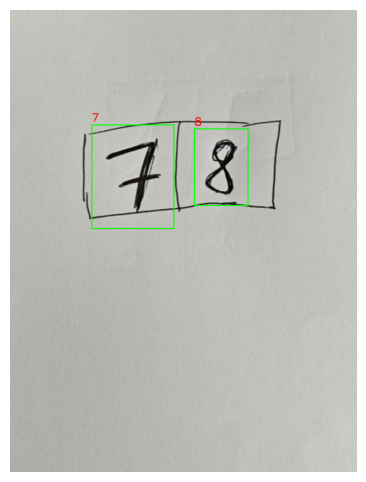

[7, 8]


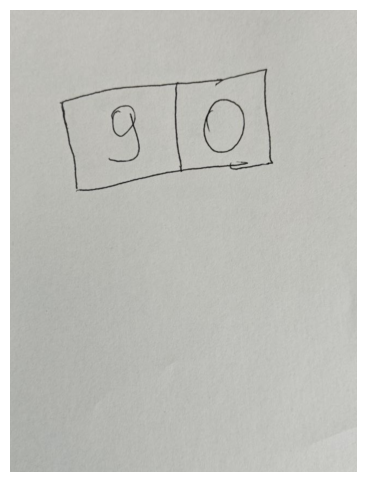

[]


In [181]:
l = ['/kaggle/input/111111111/5390813023616234421.jpg', '/kaggle/input/111111111/5390813023616234422.jpg', '/kaggle/input/111111111/5390813023616234423.jpg', '/kaggle/input/111111111/5390813023616234424.jpg', '/kaggle/input/111111111/5390813023616234425.jpg']
for i in l:
    input_path = i
    output_path = 'annotated.jpg'
    rec = recognize_and_annotate(input_path, output_path=output_path, show=True)
    print(rec)